# Generation of data using Monte Carlo method of quantum trajectories

In this notebook, we populate the folder `data\trajectories` with data of photon-counting quantum trajectories simulated with Qutip.

## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
from qutip import *
from tqdm import tqdm
from numpy import sqrt

from src.functions import *
from datetime import date

In order to benefit from parallelization, we set up the number of available CPUs for Qutip to use

In [14]:
max_cpus=19
qutip.settings.num_cpus = max_cpus

## Generation of training data for 1D case (estimation of $\Delta$)

Set up parameter to create the model of the system in Qutip

In [15]:
N=2
omega=1
gamma=1

- I will generate randomly the parameters, and only one trajectory per parameter, in order to avoid any weird information leaking.
- Number of clicks per trajectory: `njumpsMC`
- Total number of trajectories generated for training: `ndeltas`

In [23]:
# Number of clicks per trajectory
njumpsMC=48 

# Number of total trajectories to generate 
ndeltas = 40000

# Generation of a list of random values of Delta
deltamin = 0
deltamax = 5.
delta_rand_list = deltamin + (deltamax-deltamin)*rand(ndeltas)
omega_list = omega*np.ones(ndeltas)

param_rand_list = list(zip(delta_rand_list,omega_list))

In [24]:
trajectories = np.asarray(parallel_map(generate_clicks_Params, param_rand_list, task_kwargs=dict(njumpsMC = njumpsMC, gamma=gamma), progress_bar = True))

10.0%. Run time:  30.19s. Est. time left: 00:00:04:31
20.0%. Run time:  59.58s. Est. time left: 00:00:03:58
30.0%. Run time:  88.86s. Est. time left: 00:00:03:27
40.0%. Run time: 117.55s. Est. time left: 00:00:02:56
50.0%. Run time: 145.63s. Est. time left: 00:00:02:25
60.0%. Run time: 173.91s. Est. time left: 00:00:01:55
70.0%. Run time: 202.38s. Est. time left: 00:00:01:26
80.0%. Run time: 233.19s. Est. time left: 00:00:00:58
90.0%. Run time: 262.33s. Est. time left: 00:00:00:29
100.0%. Run time: 291.50s. Est. time left: 00:00:00:00
Total run time: 291.54s


The trajectories created have the form of time delays

In [25]:
trajectories.shape

(40000, 48)

In [26]:
trajectories[0]

array([ 0.97355698,  3.14583654,  0.92837564,  1.25674724,  1.7043633 ,
        0.98801792,  3.77202306,  1.43700443,  0.42911456,  5.66092247,
        2.35413675,  7.68521574,  1.37405017,  1.09481645,  1.31739269,
       10.51830509, 23.71964845, 10.03855519,  1.97720152,  1.20879205,
        2.299404  ,  9.84965304,  0.70212776,  9.60677387,  9.2210284 ,
        4.65391905,  7.85627607,  2.83611135,  3.40048759,  0.90513473,
        3.36286063,  4.78332998,  3.56720138,  3.95651093,  8.37924089,
        1.78946586, 12.39580418,  0.53172449, 11.3972001 , 15.15629954,
        1.30601504, 11.2315595 ,  1.22723439,  4.56218472,  1.13618638,
        2.74549974,  0.54310553,  2.60053517])

Save the trajetories into the `data/training/1D-delta` folder

In [27]:
# Save files to disk
# Save files to disk
datestr = date.today().strftime("%d-%m-%Y")

filename = f'data/training/1D-delta/taus-Delta-1D'
filenameDeltas = f'data/training/1D-Delta/delta_rand_list-Delta-1D'

np.save(filename,trajectories)
np.save(filenameDeltas,delta_rand_list)

## Generation of training data for 2D case (estimation of $\Delta$ and $\Omega$)

We sample the parameters randomly, and create only one trajectory per parameter

In [28]:
nparams = 40000

deltamin = 0.
deltamax = 3.

omegamin =0.25
omegamax = 5.

omega_rand_list = omegamin + (omegamax-omegamin)*rand(nparams)
delta_rand_list = deltamin + (deltamax-deltamin)*rand(nparams)

In [29]:
param_rand_list = list(zip(delta_rand_list,omega_rand_list))
param_rand_array = np.array(param_rand_list)

Visualization of the distribution of parameters sampled for training

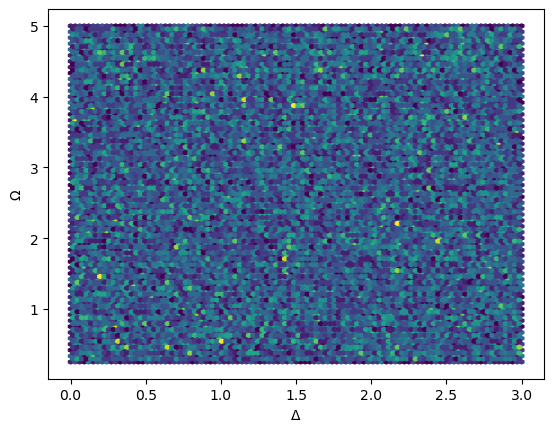

In [30]:
plt.hexbin(delta_rand_list,omega_rand_list)
plt.xlabel('$\Delta$'); plt.ylabel('$\Omega$')
plt.show()

In [31]:
trajectories = np.array(parallel_map(generate_clicks_Params, param_rand_list,num_processes=19, progress_bar = True))

10.0%. Run time:  15.34s. Est. time left: 00:00:02:18
20.0%. Run time:  29.88s. Est. time left: 00:00:01:59
30.0%. Run time:  44.17s. Est. time left: 00:00:01:43
40.0%. Run time:  58.55s. Est. time left: 00:00:01:27
50.0%. Run time:  73.06s. Est. time left: 00:00:01:13
60.0%. Run time:  88.01s. Est. time left: 00:00:00:58
70.0%. Run time: 103.22s. Est. time left: 00:00:00:44
80.0%. Run time: 118.45s. Est. time left: 00:00:00:29
90.0%. Run time: 133.62s. Est. time left: 00:00:00:14
100.0%. Run time: 148.74s. Est. time left: 00:00:00:00
Total run time: 148.79s


Save the trajetories into the `data/training/2D-delta-omega` folder

In [32]:
# Save files to disk
datestr = date.today().strftime("%d-%m-%Y")

filename = f'data/training/2D-delta-omega/taus-2D'
filenameParams = f'data/training/2D-delta-omega/param_rand_list-2D'

np.save(filename,trajectories)
np.save(filenameParams,param_rand_array)

## Generation of validation clicks for 1D case

Setup Qutip operators

In [10]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`

- Number of trajectories for each value of the grid of parameters: `ntraj`



In [11]:
ndelta = 40
ntraj = 10000

def to_time_delay_matrix(matrix):
    return np.concatenate((np.reshape(matrix[:,0],(matrix.shape[0],1)),np.diff(matrix)),axis=1)


omega=1
deltaMax = 2.1
t0=0

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep

deltagrid = np.linspace(0.,deltaMax,ndelta)
jumpArray = np.zeros((ndelta,ntraj,njumpsMC))

In [5]:
for idx_delta in tqdm(range(ndelta)):
    delta = deltagrid[idx_delta]
    # Estimate the final time to have, on average, njumpsSim jumps
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[t0,tf] # 

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete 
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx_delta,:,:] = np.asarray(trajs_completed)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


In [6]:
np.save(f"data/validation/1D-delta/validation-trajectories-1D-delta-nsets-{ntraj}",jumpArray)
np.save(f"data/validation/1D-delta/validation-deltas-1D-delta-nsets-{ntraj}.npy",deltagrid)

## Generation of validation clicks for 2D case

Setup Qutip operators

In [12]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter pairs, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`
- Number of points in the grid of $\Omega$ values considered for the validation: `nomega`
- Number of trajectories for each value of the square grid of parameters: `ntraj`



In [13]:
ndelta = 40
nomega = 40

ntraj = 10000
deltamin = 0.
deltamax = 2.1

omegamin =0.25
omegamax = 2.1

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep


deltagrid = np.linspace(deltamin,deltamax,ndelta)
omegagrid = np.linspace(omegamin,omegamax,nomega)

def gen_param_list(array1,array2):
    return np.array(np.meshgrid(array1,array2)).T.reshape(-1,2)

param_grid = gen_param_list(deltagrid,omegagrid)
nparams = ndelta*nomega

jumpArray = np.zeros((nparams,ntraj,njumpsMC))

In [15]:
for idx in tqdm(range(nparams)):
    delta = param_grid[idx][0]
    omega = param_grid[idx][1]
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[t0,tf] # 

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete 
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx,:,:] = np.asarray(trajs_completed)

  0%|          | 0/1600 [00:00<?, ?it/s]

  4%|▍         | 60/1600 [4:09:22<109:04:52, 255.00s/it]

In [ ]:
np.save(f"data/validation/2D-delta-omega/validation-trajectories-1D-delta-nsets-{ntraj}",jumpArray)
np.save(f"data/validation/2D-delta-omega/validation-deltas-1D-delta-nsets-{ntraj}.npy",deltagrid)